# MS027 Preprocess
01/29/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS027'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw/MS027_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2300031  =      0.000 ...  2246.124 secs...


In [7]:
mne_data

<RawEDF | MS027_SWB.edf, 276 x 2300032 (2246.1 s), ~4.73 GB, data loaded>

In [9]:
# mne_data.ch_names

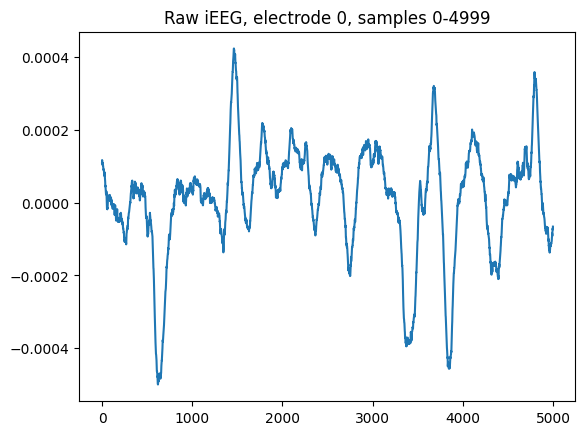

In [10]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [11]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   25.6s finished


<RawEDF | MS027_SWB.edf, 276 x 1123062 (2246.1 s), ~2.31 GB, data loaded>

### Photodiode
- examine photodiode 

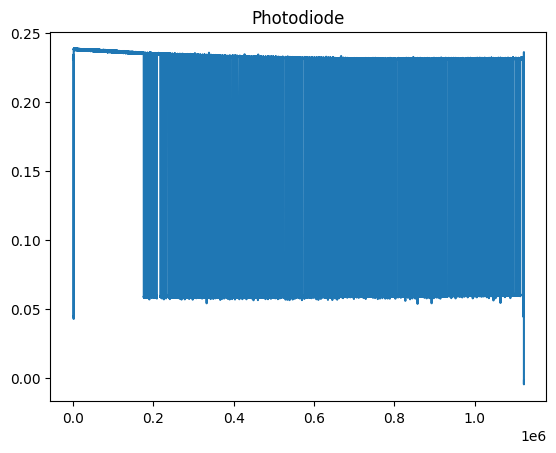

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

### Notch filter line noise

In [15]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   11.2s finished


<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

### Anatomical Localization

In [16]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [17]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -1.996863  29.154473 -12.396027  -1.489100   
1     LaCaS2    A32sg_L  -2.396240  31.151354  -7.997437  -2.305976   
2     LaCaS3    A32sg_L  -3.194992  33.148236  -3.198975  -3.581341   
3     LaCaS4    A24rv_L  -3.594368  35.145118   1.199615  -4.402200   
4     LaCaS5    A24rv_L  -4.393121  37.141999   5.598206  -5.612624   
..       ...        ...        ...        ...        ...        ...   
143   RHplT8     A21c_R  50.321429 -29.953224 -17.194489  58.208197   
144   RHplT9     A21c_R  54.315191 -32.748859 -15.994873  62.645023   
145  RHplT10     A21c_R  58.308954 -35.145117 -15.195129  67.068103   
146  RHplT11     A21c_R  62.702093 -37.940751 -13.995514  71.887967   
147  RHplT12    Unknown  66.695856 -40.337009 -13.195770  76.203414   

         mni_y      mni_z       gm                                 NMM  \
0    25.800180 -10.918105     Gray  Left ACgG anterior cingulate gyrus   
1    28.213844  -6.269909     Gray  Left ACgG anterior cingulate gyrus   
2    30.463378  -1.114084    White  Left ACgG anterior cingulate gyrus   
3    32.551975   3.559879    White  Left ACgG anterior cingulate gyrus   
4    34.849006   8.272237    White  Left ACgG anterior cingulate gyrus   
..         ...        ...      ...                                 ...   
143 -32.244283  -9.492322     Gray         Right Cerebral White Matter   
144 -35.095643  -8.145739     Gray     Right MTG middle temporal gyrus   
145 -37.522830  -7.125109     Gray     Right MTG middle temporal gyrus   
146 -40.228714  -5.508332  Unknown     Right MTG middle temporal gyrus   
147 -42.491792  -4.278632  Unknown                             Unknown   

         Anat                AnatMacro    BN246  \
0    Area s24       L Olfactory cortex     L CG   
1    Area s24                    L ACC     L CG   
2     Area 33                    L ACC     L CG   
3     Unknown                    L ACC     L CG   
4     Area 33                    L ACC     L CG   
..        ...                      ...      ...   
143   Unknown  R Middle Temporal Gyrus    R MTG   
144   Unknown  R Middle Temporal Gyrus    R MTG   
145   Unknown  R Middle Temporal Gyrus    R MTG   
146   Unknown  R Middle Temporal Gyrus    R MTG   
147   Unknown                  Unknown  Unknown   

                                      YBA_1 ManualExamination Note  
0                    Left cingulate gyrus C               NaN  NaN  
1                    Left cingulate gyrus C               NaN  NaN  
2                                   Unknown                WM  NaN  
3                                   Unknown                WM  NaN  
4                    Left cingulate gyrus F                WM  NaN  
..                                      ...               ...  ...  
143  Right inferior middle temporal gyrus D               NaN  NaN  
144  Right inferior middle temporal gyrus D               NaN  NaN  
145  Right inferior middle temporal gyrus E               OOB  NaN  
146  Right superior middle temporal gyrus E               OOB  NaN  
147                                 Unknown               OOB  NaN  

[148 rows x 16 columns]

In [18]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LiIsP1',
 'LiIsP2',
 'LiIsP3',
 'LiIsP4',
 'LiIsP5',
 'LiIsP6',
 'LiIsP7',
 'LiIsP8',
 'LiIsP9',
 'LiIsP10',
 'LiIsP11',
 'LiIsP12',
 'LiIsP13',
 'LiIsP14',
 'LiIsP15',
 'LiIsP16',
 'Lence1',
 'Lence2',
 'Lence3',
 'Lence4',
 'Lence5',
 'Lence6',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'Rm

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lilsp1', 'lilsp2', 'lilsp3', 'lilsp4', 'lilsp5', 'lilsp6', 'lilsp7', 'lilsp8', 'lilsp9', 'lilsp10', 'lilsp11', 'lilsp12', 'lilsp13', 'lilsp14', 'lilsp15', 'lilsp16', 'ralsp1', 'ralsp2', 'ralsp3', 'ralsp4', 'ralsp5', 'ralsp6', 'ralsp7', 'ralsp8', 'ralsp9', 'ralsp10', 'ralsp11', 'ralsp12', 'ralsp13', 'ralsp14', 'ralsp15', 'ralsp16', 'lenc1', 'lenc2', 'lenc3', 'lenc4', 'lenc5', 'lenc6', 'c157', 'c158', 'c159', 'c160', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230',

In [20]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [21]:
unmatched_seeg #make sure there are no unmatched names


[]

In [22]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [23]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'rmolf10': 'rmolf10',
 'rmolf11': 'rmolf11',
 'rmolf12': 'rmolf12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lm

In [24]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [25]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 74 left sEEG and 74 right sEEG electrodes
We have a total of 148 sEEG electrodes


In [26]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [27]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS027_SWB.edf, 148 x 1123062 (2246.1 s), ~1.24 GB, data loaded>

In [28]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS027_SWB.edf, 148 x 1123062 (2246.1 s), ~1.24 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [29]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [30]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [31]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'lence': 6,
 'lhplt': 10,
 'liisp': 16,
 'lmcms': 10,
 'lmolf': 10,
 'racas': 12,
 'raglt': 12,
 'raisp': 16,
 'rhplt': 12,
 'rmcms': 10,
 'rmolf': 12}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [142]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['liisp12', 'raglt8', 'raisp11', 'raisp14', 'raisp15', 'rhplt7']

<IPython.core.display.Javascript object>


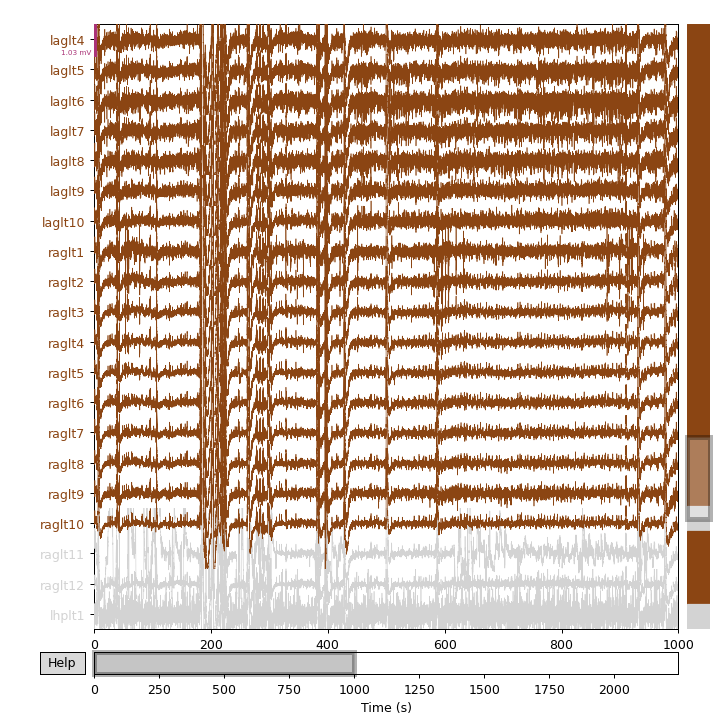

In [147]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max()/20)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


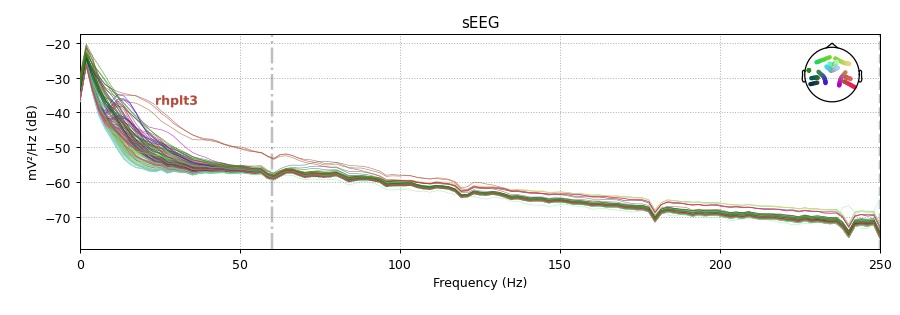

<IPython.core.display.Javascript object>


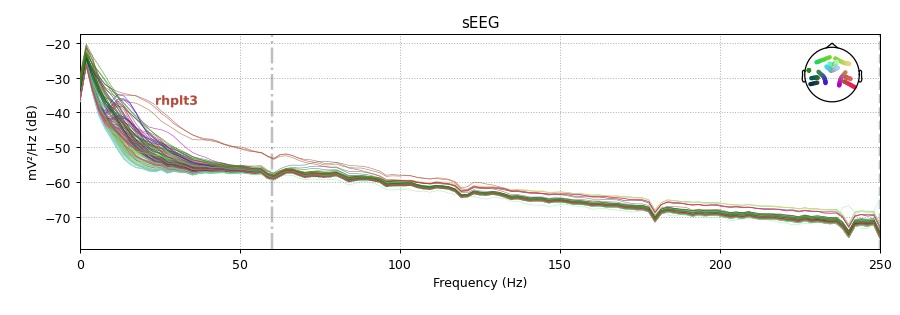

In [146]:
mne_data.compute_psd().plot()

In [148]:
mne_data.info['bads']

['lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt1',
 'raglt11',
 'lence1',
 'raglt12',
 'lence2',
 'lence3',
 'lence4',
 'lence5',
 'lence6']

In [149]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 12 items (lhplt2, lhplt3, lhplt4, lhplt1, raglt11, lence1, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 148 sEEG
 custom_ref_applied: False
 dig: 148 items (148 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 09:35:07 UTC
 meas_id: 4 items (dict)
 nchan: 148
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [150]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [151]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=40, n_times=1123062
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lmolf1-lmolf2, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf9-lmolf10, liisp1-liisp2, liisp2-liisp3, liisp3-liisp4, liisp4-liisp5, liisp5-liisp6, laglt1-laglt2, laglt2-laglt3, laglt7-laglt8, laglt8-laglt9, rmcms1-rmcms2, rmcms2-rmcms3, rmcms3-rmcms4, rmcms6-rmcms7, rmcms7-rmcms8, rmolf5-rmolf6, rmolf9-rmolf10, raisp1-raisp2, raisp2-raisp3, raisp5-raisp6, raisp6-raisp7, raisp7-raisp8, raisp8-raisp9, raisp9-raisp10, raisp14-raisp15, raisp15-raisp16, raglt1-raglt2, raglt2-raglt3, raglt5-raglt6, rhplt1-rhplt2, rhplt2-rhplt3, rhplt8-rhplt9


In [152]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 40 x 1123062 (2246.1 s), ~342.8 MB, data loaded>

In [153]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lmolf1-lmolf2',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf9-lmolf10',
 'liisp1-liisp2',
 'liisp2-liisp3',
 'liisp3-liisp4',
 'liisp4-liisp5',
 'liisp5-liisp6',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms6-rmcms7',
 'rmcms7-rmcms8',
 'rmolf5-rmolf6',
 'rmolf9-rmolf10',
 'raisp1-raisp2',
 'raisp2-raisp3',
 'raisp5-raisp6',
 'raisp6-raisp7',
 'raisp7-raisp8',
 'raisp8-raisp9',
 'raisp9-raisp10',
 'raisp14-raisp15',
 'raisp15-raisp16',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt5-raglt6',
 'rhplt1-rhplt2',
 'rhplt2-rhplt3',
 'rhplt8-rhplt9']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


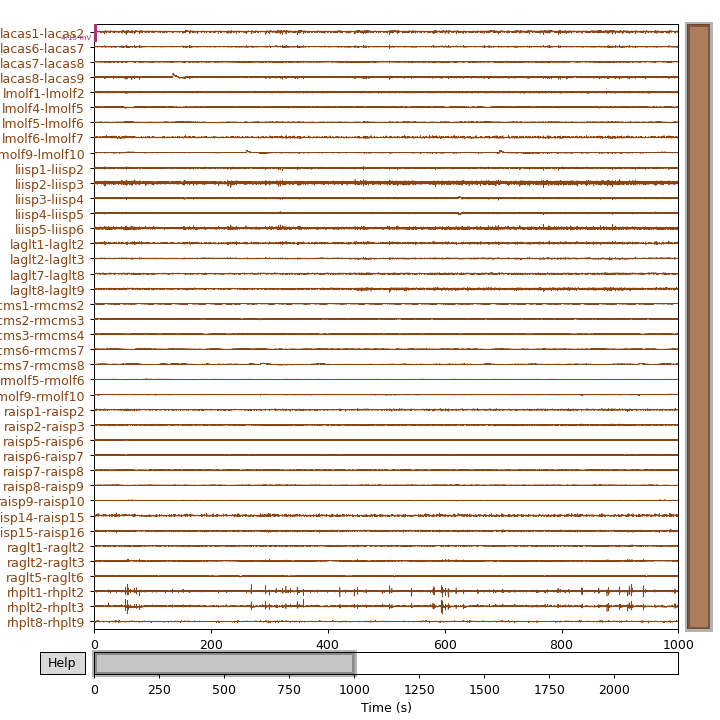

In [154]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


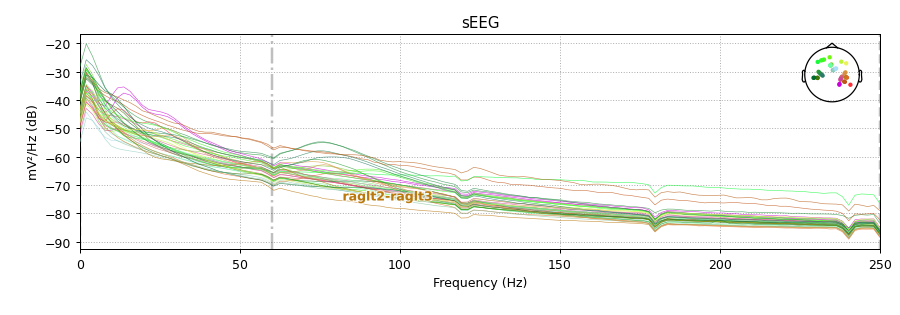

<IPython.core.display.Javascript object>


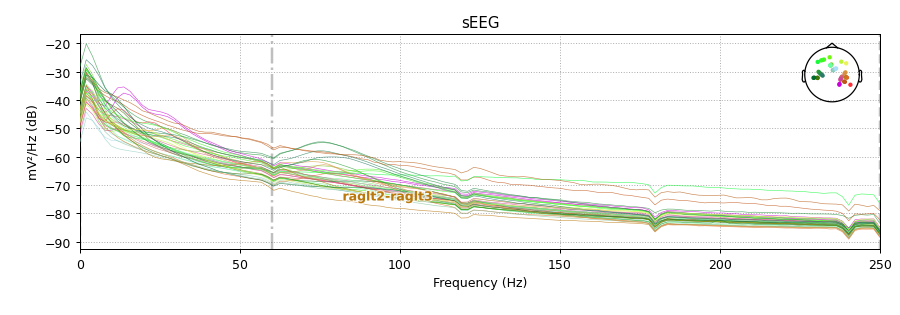

In [155]:
mne_data_bp_reref.compute_psd().plot()

In [156]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif
[done]


## Save mne_data

In [157]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [158]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [46]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif...
Isotrak not found
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...


In [47]:
photodiode_data

<Raw | photodiode.fif, 1 x 1123062 (2246.1 s), ~8.6 MB, data loaded>

In [6]:
# plt.plot(scipy.stats.zscore(photodiode_data._data[0:]))
plt.plot(photodiode_data._data[:])
# plt.plot(temp_diode._data[1000000:1100000])
# plt.plot(temp_diode._data[1000000:1300000])
# plt.plot(temp_diode._data[:])
# plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.title("Photodiode")
plt.show()

NameError: name 'photodiode_data' is not defined

In [101]:
temp_diode = photodiode_data.copy()
# temp_data = -temp_diode._data[0,:]
temp_data = temp_diode._data[0,:]
# temp_data = np.abs(temp_data-np.nanmax(temp_data)) #consider resaving photodiode 
# temp_data = np.abs(temp_diode._data[0, :])
# temp_data[0:1250000] = 0
temp_diode._data = -temp_data

In [115]:
### Photodiode alignment
smoothSize=11
windSize=15
height=-1.3

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

34 blocks
..................................

found matches for 15 of 512 pulses


In [159]:
print(slope, offset,smoothSize,windSize,height)

0.9999887352787503 3.9169923099667585 11 15 -1.3


In [117]:
[(x*slope + offset) for x in beh_ts]

[434.67705226323346,
 444.34715173114677,
 454.2768273749215,
 473.9955942459643,
 484.152936125039,
 494.507724379761,
 509.39485277866737,
 521.6653238535591,
 532.4862332577761,
 548.2570727016282,
 558.4291782143545,
 569.3505360870588,
 586.4186979167966,
 597.5116551561224,
 607.2524497275587,
 623.2989388664797,
 633.7627979926733,
 645.0033953689664,
 657.1801369997382,
 666.6299352492387,
 677.2848847228258,
 689.5474051873919,
 699.9614775744851,
 710.4134382346824,
 725.2781186864274,
 734.6192603598009,
 743.9974496159828,
 760.9421270368748,
 771.8051893661489,
 782.1234873319536,
 798.1715664527308,
 807.9141647039626,
 817.1664169786449,
 834.3847683164865,
 844.6255587556731,
 854.5749658771305,
 869.766642545244,
 880.1211436033427,
 890.2909849415634,
 914.2440254140972,
 922.4884359421204,
 938.1792637874705,
 948.5247670467493,
 960.3354059016925,
 975.7427376405689,
 987.8055742545354,
 997.5058241825875,
 1012.154637165975,
 1022.3852093202264,
 1031.5178385423983

In [141]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [160]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [161]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [162]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [163]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.9s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 40 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 40 columns


In [164]:
epochs_all_evs 


{'TrialOnset': <Epochs |  147 events (all good), -2 - 1 sec, baseline off, ~67.4 MB, data loaded, with metadata,
  'TrialOnset': 147>,
 'DecisionOnset': <Epochs |  147 events (all good), -1 - 6 sec, baseline off, ~157.2 MB, data loaded, with metadata,
  'DecisionOnset': 147>}

### Add behavioral data to metadata 

In [165]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [166]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [167]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 98 columns
Replacing existing metadata with 98 columns


In [168]:
epochs_all_evs[event].metadata

lacas1-lacas2 lacas6-lacas7 lacas7-lacas8 lacas8-lacas9 lmolf1-lmolf2  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN           NaN           NaN   
2             NaN     [461.306]           NaN           NaN         noise   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
142         noise    [2177.176]           NaN           NaN           NaN   
143           NaN           NaN           NaN           NaN           NaN   
144           NaN           NaN           NaN           NaN           NaN   
145           NaN           NaN           NaN           NaN           NaN   
146           NaN           NaN         noise           NaN           NaN   

    lmolf4-lmolf5 lmolf5-lmolf6 lmolf6-lmolf7 lmolf9-lmolf10 liisp1-liisp2  \
0             NaN           NaN           NaN            NaN           NaN   
1             NaN           NaN           NaN            NaN           NaN   
2             NaN           NaN           NaN            NaN           NaN   
3           noise           NaN           NaN            NaN           NaN   
4             NaN           NaN           NaN            NaN           NaN   
..            ...           ...           ...            ...           ...   
142           NaN           NaN           NaN            NaN           NaN   
143           NaN           NaN           NaN            NaN           NaN   
144           NaN           NaN           NaN            NaN           NaN   
145           NaN           NaN           NaN            NaN           NaN   
146           NaN           NaN           NaN            NaN           NaN   

     ... util_dCPE_emmap util_tCF_emmap util_dCF_emmap util_tRegret_emmap  \
0    ...        0.313744      -0.205170       0.000000           0.000000   
1    ...       -0.221612       0.000000       0.000000          -0.221612   
2    ...       -0.410340       0.000000       0.000000          -0.410340   
3    ...       -0.091145       0.000000       0.627488           0.000000   
4    ...       -0.043986       0.584054       0.584054          -0.043986   
..   ...             ...            ...            ...                ...   
142  ...        0.410340      -0.326970      -0.410340           0.000000   
143  ...        0.445090       0.000000       0.000000           0.000000   
144  ...       -0.348609       0.849561       0.000000          -1.198170   
145  ...       -0.024015      -0.267047      -0.267047           0.000000   
146  ...        0.429439      -0.429439      -0.429439           0.000000   

    util_dRegret_emmap util_tRelief_emmap util_dRelief_emmap util_RPE_emmap  \
0             0.000000           0.518914           0.313744       0.205170   
1            -0.221612           0.000000           0.000000       0.000000   
2            -0.410340           0.000000           0.000000       0.000000   
3             0.000000           0.536343          -0.091145       0.000000   
4            -0.043986           0.000000           0.000000       0.000000   
..                 ...                ...                ...            ...   
142           0.000000           0.326970           0.410340       0.326970   
143           0.000000           0.445090           0.445090       0.000000   
144          -0.348609           0.000000           0.000000      -0.849561   
145           0.000000          -0.024015          -0.024015       0.000000   
146           0.000000           0.429439           0.429439       0.000000   

    util_pRPE_emmap util_nRPE_emmap  
0           0.20517        0.000000  
1           0.00000        0.000000  
2           0.00000        0.000000  
3           0.00000        0.000000  
4           0.00000        0.000000  
..              ...             ...  
14

### Save raw epoched data 

In [169]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [170]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [171]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [172]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [173]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [174]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 40, ~674.4 MB>}

In [175]:
power_epochs = {}

In [176]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 98 columns


In [177]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 40, ~3.29 GB>

In [178]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [179]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01292024


In [140]:
#to reload for more cleaning if necessary
mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)
del epochs_all_baseline, power_epochs, plot_data

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...


3.9169923099667585


<IPython.core.display.Javascript object>


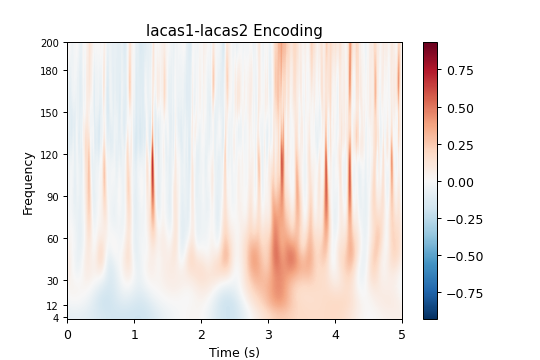

<IPython.core.display.Javascript object>


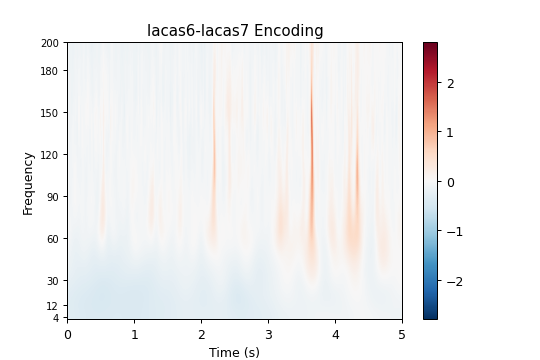

<IPython.core.display.Javascript object>


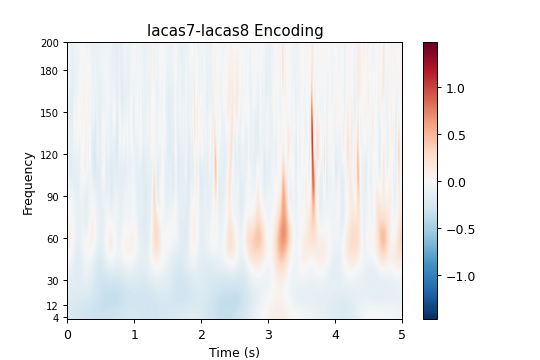

<IPython.core.display.Javascript object>


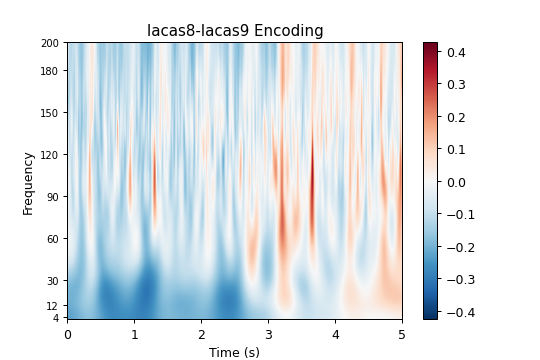

<IPython.core.display.Javascript object>


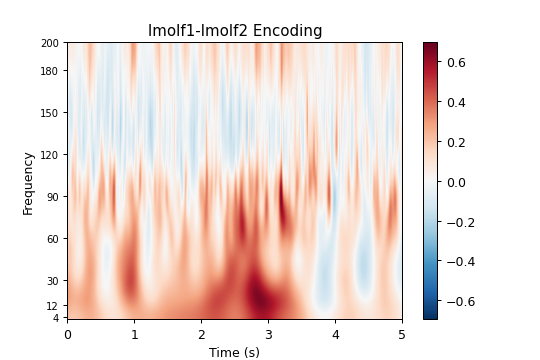

<IPython.core.display.Javascript object>


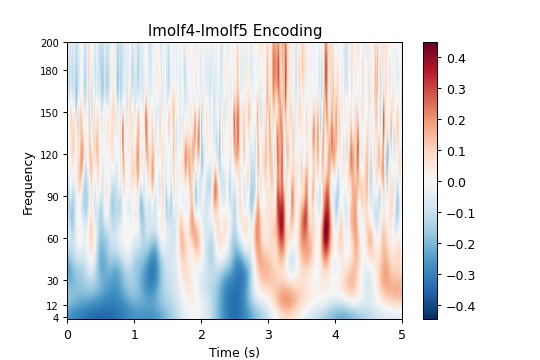

<IPython.core.display.Javascript object>


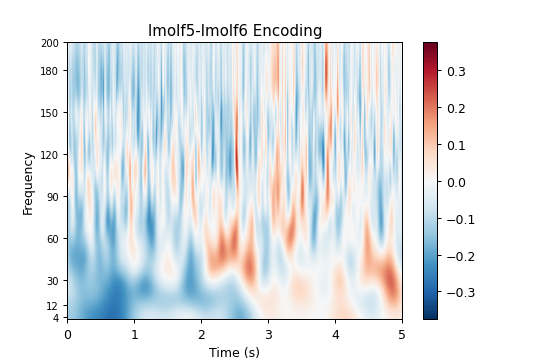

<IPython.core.display.Javascript object>


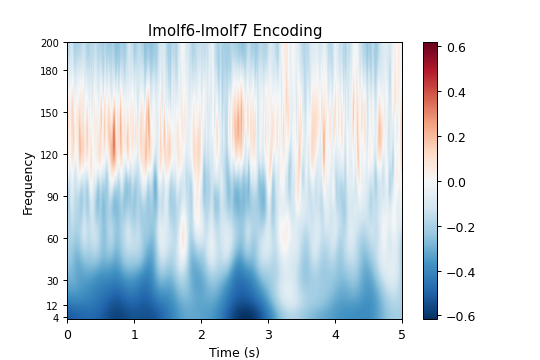

<IPython.core.display.Javascript object>


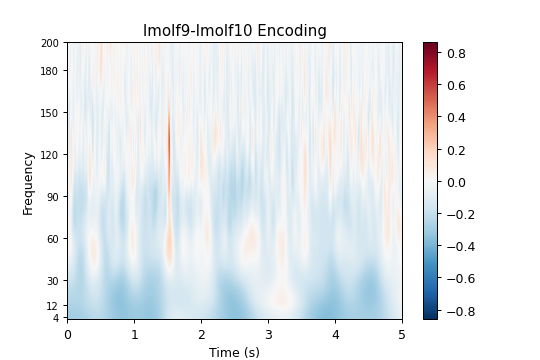

<IPython.core.display.Javascript object>


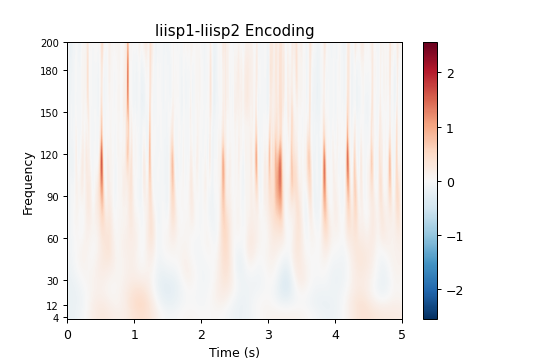

<IPython.core.display.Javascript object>


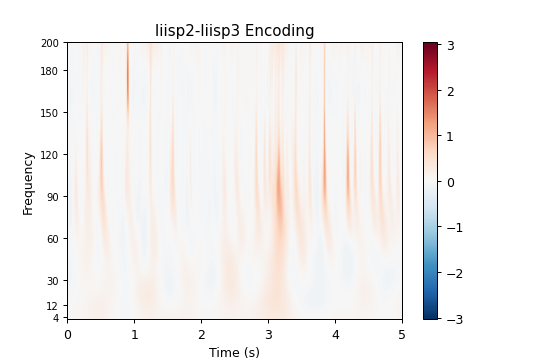

<IPython.core.display.Javascript object>


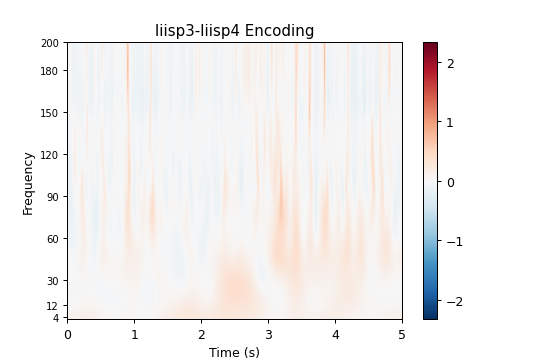

<IPython.core.display.Javascript object>


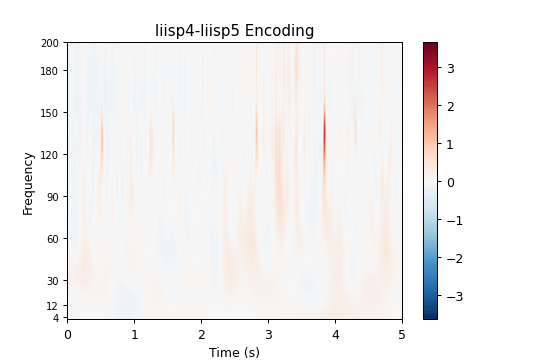

<IPython.core.display.Javascript object>


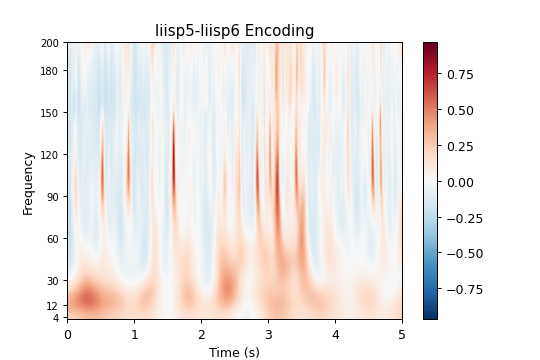

<IPython.core.display.Javascript object>


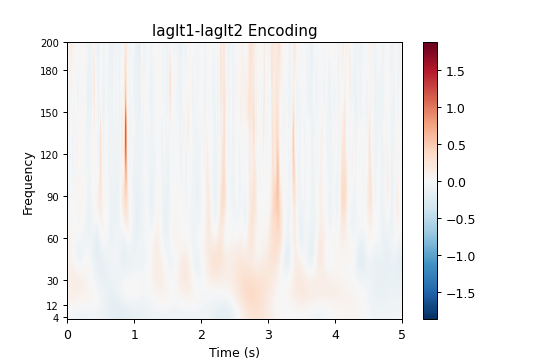

<IPython.core.display.Javascript object>


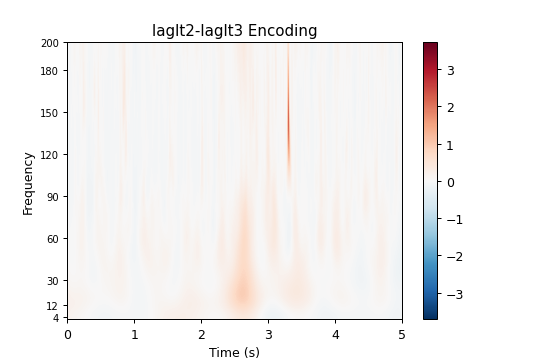

<IPython.core.display.Javascript object>


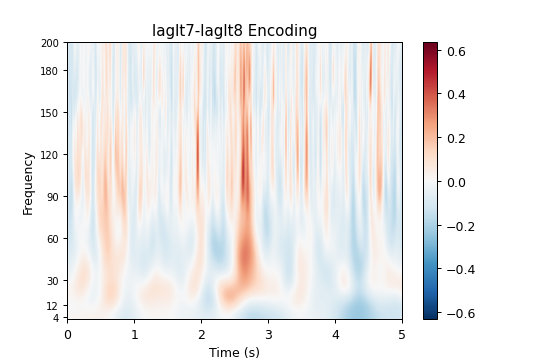

<IPython.core.display.Javascript object>


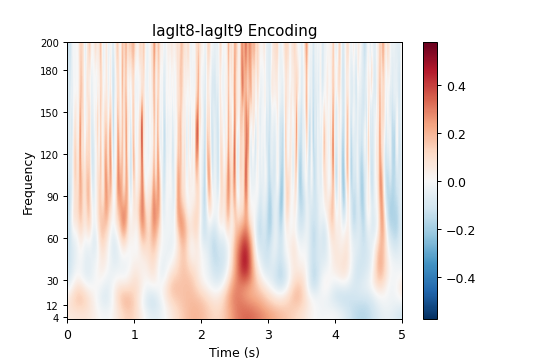

<IPython.core.display.Javascript object>


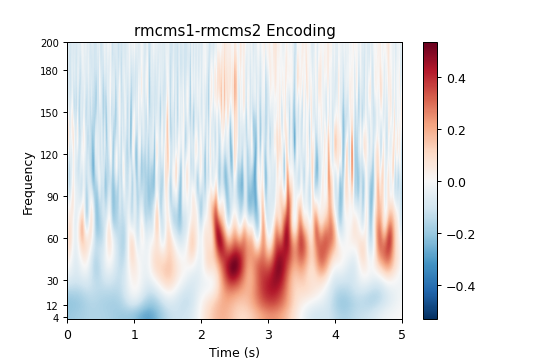

<IPython.core.display.Javascript object>


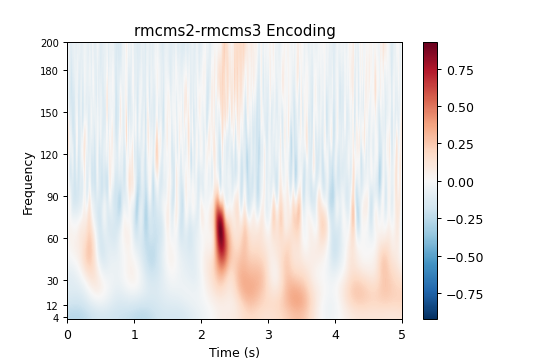

<IPython.core.display.Javascript object>


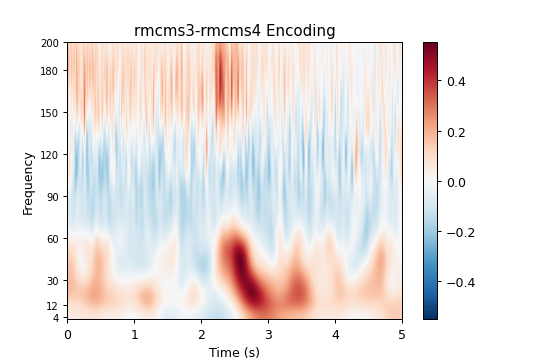

<IPython.core.display.Javascript object>


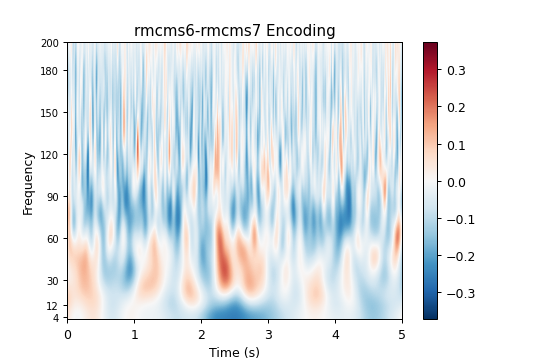

<IPython.core.display.Javascript object>


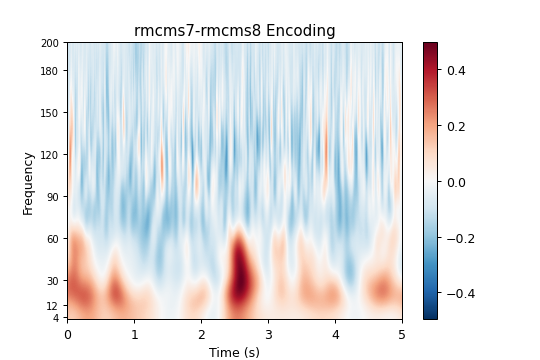

<IPython.core.display.Javascript object>


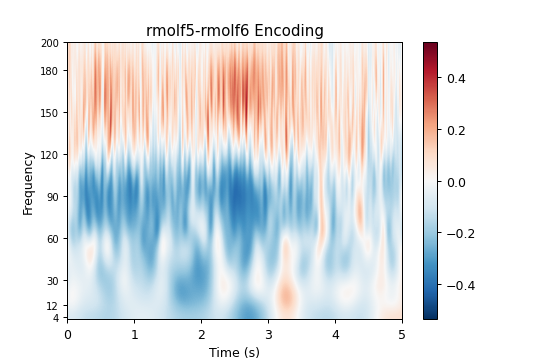

<IPython.core.display.Javascript object>


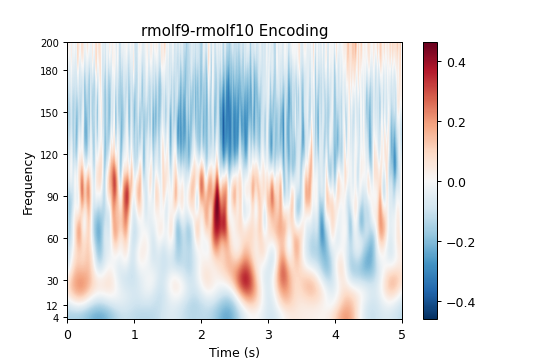

<IPython.core.display.Javascript object>


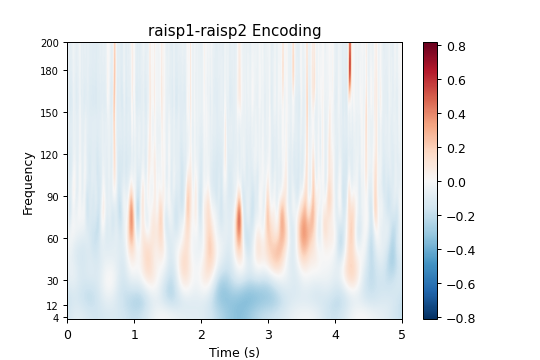

<IPython.core.display.Javascript object>


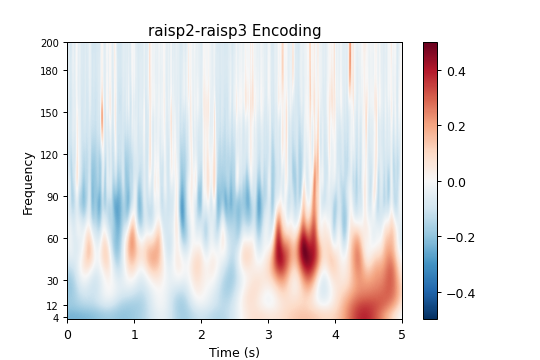

<IPython.core.display.Javascript object>


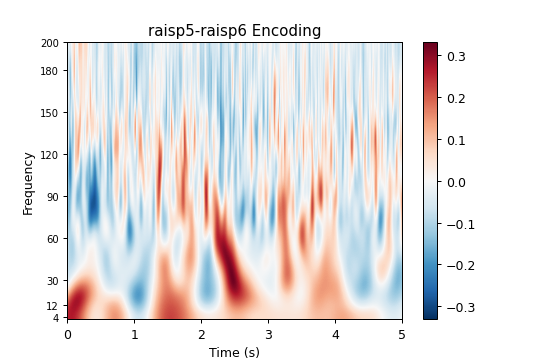

<IPython.core.display.Javascript object>


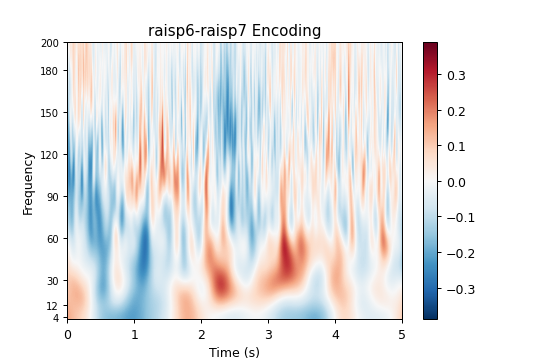

<IPython.core.display.Javascript object>


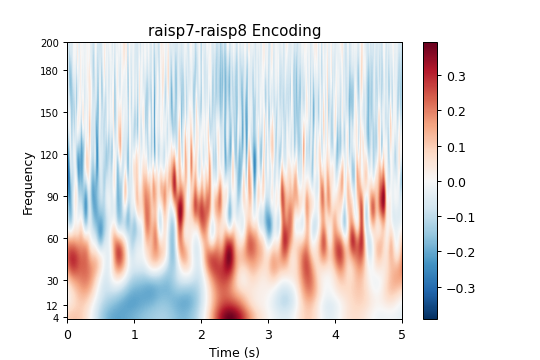

<IPython.core.display.Javascript object>


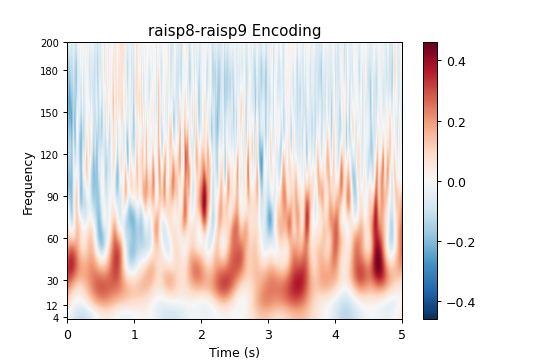

<IPython.core.display.Javascript object>


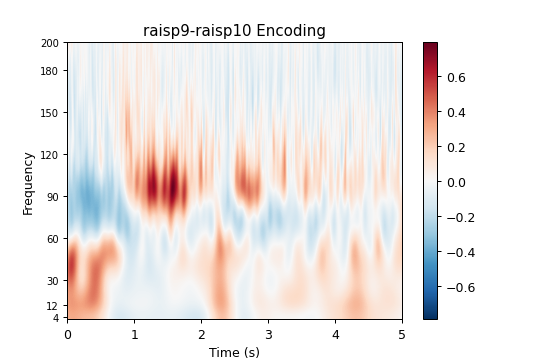

<IPython.core.display.Javascript object>


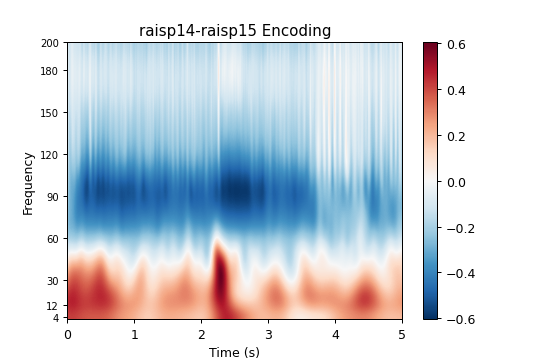

<IPython.core.display.Javascript object>


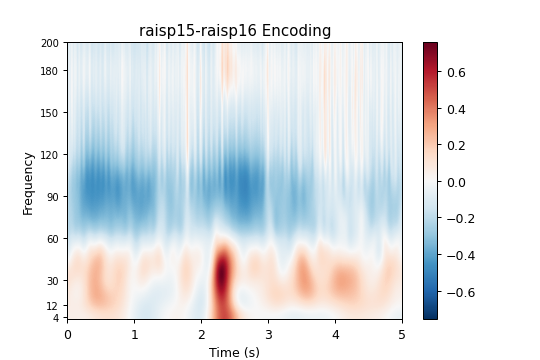

<IPython.core.display.Javascript object>


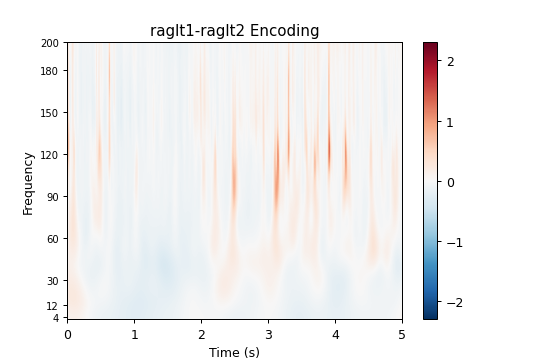

<IPython.core.display.Javascript object>


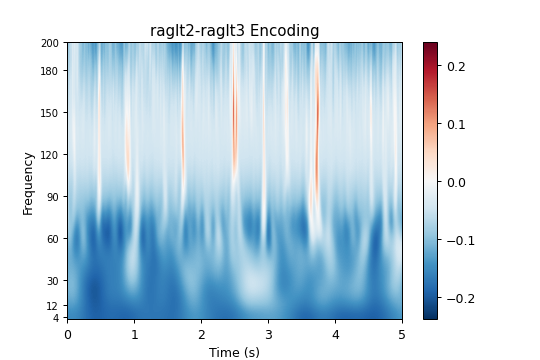

<IPython.core.display.Javascript object>


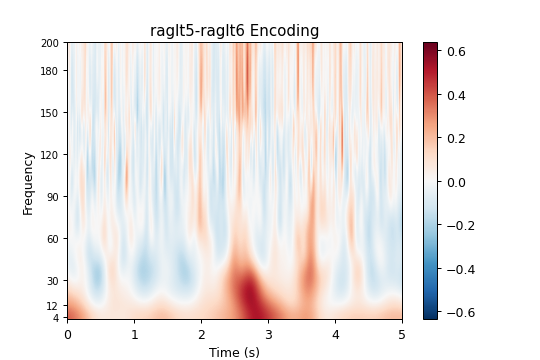

<IPython.core.display.Javascript object>


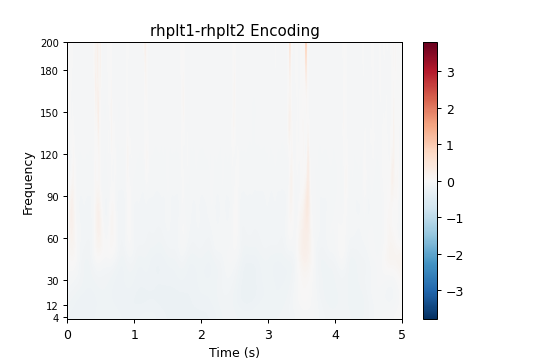

<IPython.core.display.Javascript object>


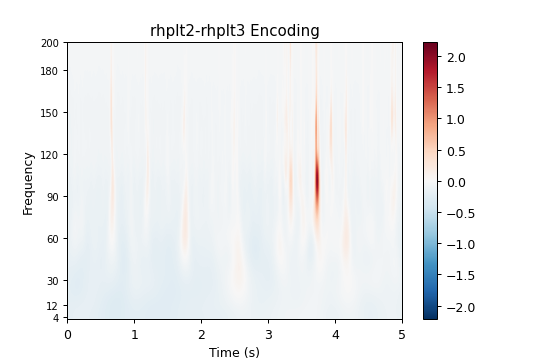

<IPython.core.display.Javascript object>


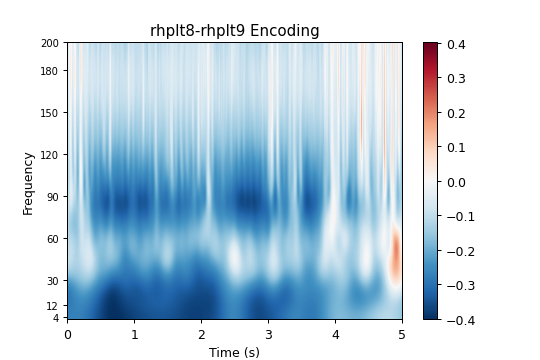

In [180]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
